## SOMMAIRE :

Préparation

Chapitre 1 : Analyse d'un fichier sans erreur

Chapitre 2 : Analyse d'un fichier avec erreur

Conclusion

## Préparation

### Import des dépendances

In [1]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm # Affichage d'une barre de progression
import difflib # Recherche de similarité entre deux chaînes de caractères
import pandas as pd

# Import des fonctions personnalisées qui seront utilisées dans ce notebook
from modules_nlp.process_departure_destination import extract_departure_destination, process_dataset, compare_triplets, preprocess_triplets

# Chargement du modèle entrainé
nlp_itineraire = spacy.load("./model-best/")

# Chargement du modèle Français medium - Ce modèle sera utilisé pour la détection des langues
nlp_fr = spacy.load("fr_core_news_md")

### Configuration du détecteur de langue

In [2]:
# Installation du package de détection de la langue
! pip install spacy-langdetect 

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
from spacy.language import Language
from spacy_langdetect import LanguageDetector


@Language.factory('language_detector')
def language_detector(nlp, name):
    return LanguageDetector()

# Ajouter LanguageDetector à la pipeline si ce n'est pas déjà le cas
if 'language_detector' not in nlp_fr.pipe_names:
    print("Ajout de LanguageDetector à la pipeline")
    nlp_fr.add_pipe('language_detector', last=True)
    print("LanguageDetector ajouté à la pipeline")

# # Décommenter le code ci-dessous pour tester la détection de la langue    
# text = 'This is an english text.'
# doc = nlp_fr(text)
# print(doc._.language)


Ajout de LanguageDetector à la pipeline
LanguageDetector ajouté à la pipeline


### Configuration d'une pipeline pour le traitement

In [4]:
def analyse_nlp(file_path_intput, file_path_output) :


    print("___________________________")
    print("Lecture du fichier d'entrée :")
    with open(file_path_intput, 'r') as file:
        content = file.read()
        print(content)
    print("___________________________")

    # Extraction des triplets de référence
    with open(file_path_output, 'r', encoding='utf-8') as file:
        # Ici on met chaque ligne du fichier dans une liste en supprimant le retour à la ligne ainsi que la virgule à la fin
        referenceTriplets = [line.strip().rstrip(',') for line in file.readlines()]

    print("**********************************************")
    print("ANALYSE BRUTE (SANS PRETRAITEMENT)")
    print("**********************************************")
    print("")

    outputTriplets = process_dataset(file_path_intput, nlp_fr, nlp_itineraire, True)


    # Comparaison brute (sans prétraitement)
    compare_triplets(outputTriplets, referenceTriplets)

    print("")
    print("")
    print("**********************************************")
    print("ANALYSE APRES PRETRAITEMENT")
    print("**********************************************")

    preprocessed_outputTriplets = preprocess_triplets(outputTriplets)
    preprocessed_referenceTriplets = preprocess_triplets(referenceTriplets)

    
    compare_triplets(preprocessed_outputTriplets, preprocessed_referenceTriplets)
    # print(preprocessed_outputTriplets)

## Chapitre 1 : Analyse d'un fichier sans erreur

___________________________
Lecture du fichier d'entrée :
1,je voudrais aller de Toulouse à bordeaux
2,Comment me rendre à Port-Boulet depuis la gare de Tours ?
3,Je veux aller voir mon ami Albert à Tours en partant de Bordeaux
4,Il y a-t-il des trains de Nantes à Montaigu
5,Une phrase sans origine ni destination
Si pas de numéro de séquence, on considère que c'est zéro
7, is there any train going from Paris to Marseille ?

___________________________
**********************************************
ANALYSE BRUTE (SANS PRETRAITEMENT)
**********************************************

NER originaux : 


NER itineraire : 


-----------------------------
NER originaux : 


NER itineraire : 


-----------------------------
NER originaux : 


NER itineraire : 


-----------------------------
NER originaux : 


NER itineraire : 


-----------------------------
NER originaux : 


c:\Users\PC\anaconda3\envs\nlp\Lib\site-packages\spacy\displacy\__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


NER itineraire : 


-----------------------------
NER originaux : 


NER itineraire : 


-----------------------------
NER originaux : 


NER itineraire : 


-----------------------------
Triplets extraits : 
['1,Toulouse,bordeaux', '2,Tours,Port-Boulet', '3,Bordeaux,Tours', '4,Nantes,Montaigu', '5,NOT_TRIP', '0,NOT_TRIP', '7,NOT_FRENCH']
--------------------
Erreur à la ligne 1
Triplet extrait : 1,Toulouse,bordeaux
Triplet attendu : 1,Toulouse,Bordeaux
--------------------

++++++++++++++++++++++++++++++++++++++
Taux de réussite : 85.71% : 1 erreurs sur 7 lignes.
++++++++++++++++++++++++++++++++++++++



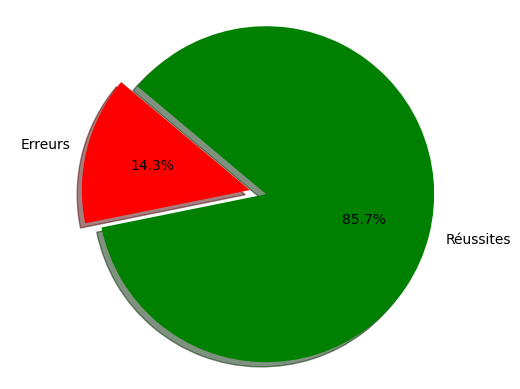


---------------------------------------------------
Tableau récapitulatif : 
  id   departure departure predict  destination destination predict
0  1    Toulouse          Toulouse     Bordeaux            bordeaux
1  2       Tours             Tours  Port-Boulet         Port-Boulet
2  3    Bordeaux          Bordeaux        Tours               Tours
3  4      Nantes            Nantes     Montaigu            Montaigu
4  5    NOT_TRIP          NOT_TRIP                                 
5  0    NOT_TRIP          NOT_TRIP                                 
6  7  NOT_FRENCH        NOT_FRENCH                                 
---------------------------------------------------



**********************************************
ANALYSE APRES PRETRAITEMENT
**********************************************
triplet original : 
['1,TOULOUSE,BORDEAUX', '2,TOURS,PORT BOULET', '3,BORDEAUX,TOURS', '4,NANTES,MONTAIGU', '5,NOT TRIP', '0,NOT TRIP', '7,NOT FRENCH']
triplet corrigé : 1,TOULOUSE,BORDEAUX
triplet cor

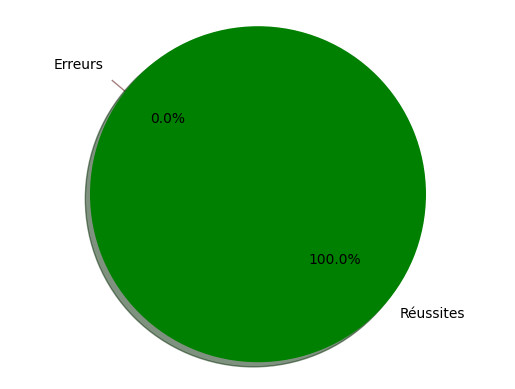


---------------------------------------------------
Tableau récapitulatif : 
  id   departure departure predict  destination destination predict
0  1    TOULOUSE          TOULOUSE     BORDEAUX            BORDEAUX
1  2       TOURS             TOURS  PORT BOULET         PORT BOULET
2  3    BORDEAUX          BORDEAUX        TOURS               TOURS
3  4      NANTES            NANTES     MONTAIGU            MONTAIGU
4  5    NOT TRIP          NOT TRIP                                 
5  0    NOT TRIP          NOT TRIP                                 
6  7  NOT FRENCH        NOT FRENCH                                 
---------------------------------------------------



In [5]:
# Chemin du fichier d'entrée (id, phrases à analyser)
file_path_intput = './samples/sample_nlp_input.txt'

# Chemin du fichier de sortie (triplets id, départ, destination)
file_path_output = './samples/sample_nlp_output.txt'

# lancement de l'analyse
analyse_nlp(file_path_intput, file_path_output)

## Chapitre 2 : Analyse d'un fichier avec erreur

___________________________
Lecture du fichier d'entrée :
1,je voudrais aller de toulouse à Bordau
2,Comment me rendre à Port-boulet depuis la gare de Tourrs ?
3,Je veux aller voir mon ami Albert à Toures en partant de Baurdeaux
4,Il y a-t-il des trains de Nanthes à Montégu
5,Une phrase sans origine ni destination
Si pas de numéro de séquence, on considère que c'est zéro
7, is there any train going from Parrie to Marceille ?

___________________________
**********************************************
ANALYSE BRUTE (SANS PRETRAITEMENT)
**********************************************

NER originaux : 


NER itineraire : 


-----------------------------
NER originaux : 


NER itineraire : 


-----------------------------
NER originaux : 


NER itineraire : 


-----------------------------
NER originaux : 


NER itineraire : 


-----------------------------
NER originaux : 


c:\Users\PC\anaconda3\envs\nlp\Lib\site-packages\spacy\displacy\__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


NER itineraire : 


-----------------------------
NER originaux : 


NER itineraire : 


-----------------------------
NER originaux : 


NER itineraire : 


-----------------------------
Triplets extraits : 
['1,toulouse,Bordau', '2,Tourrs,Port-boulet', '3,Baurdeaux,Toures', '4,Nanthes,Montégu', '5,NOT_TRIP', '0,NOT_TRIP', '7,NOT_FRENCH']
--------------------
Erreur à la ligne 1
Triplet extrait : 1,toulouse,Bordau
Triplet attendu : 1,Toulouse,Bordeaux
--------------------
--------------------
Erreur à la ligne 2
Triplet extrait : 2,Tourrs,Port-boulet
Triplet attendu : 2,Tours,Port-Boulet
--------------------
--------------------
Erreur à la ligne 3
Triplet extrait : 3,Baurdeaux,Toures
Triplet attendu : 3,Bordeaux,Tours
--------------------
--------------------
Erreur à la ligne 4
Triplet extrait : 4,Nanthes,Montégu
Triplet attendu : 4,Nantes,Montaigu
--------------------

++++++++++++++++++++++++++++++++++++++
Taux de réussite : 42.86% : 4 erreurs sur 7 lignes.
++++++++++++++++++++++++++++++++++++++



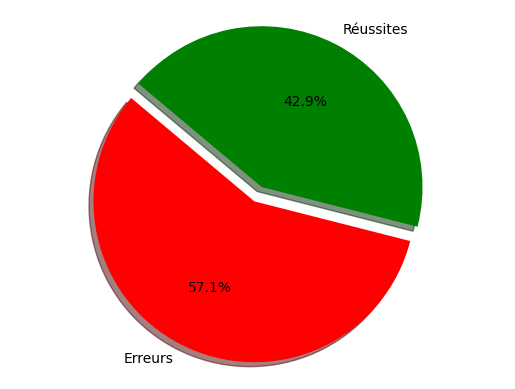


---------------------------------------------------
Tableau récapitulatif : 
  id   departure departure predict  destination destination predict
0  1    Toulouse          toulouse     Bordeaux              Bordau
1  2       Tours            Tourrs  Port-Boulet         Port-boulet
2  3    Bordeaux         Baurdeaux        Tours              Toures
3  4      Nantes           Nanthes     Montaigu             Montégu
4  5    NOT_TRIP          NOT_TRIP                                 
5  0    NOT_TRIP          NOT_TRIP                                 
6  7  NOT_FRENCH        NOT_FRENCH                                 
---------------------------------------------------



**********************************************
ANALYSE APRES PRETRAITEMENT
**********************************************
triplet original : 
['1,TOULOUSE,BORDAU', '2,TOURRS,PORT BOULET', '3,BAURDEAUX,TOURES', '4,NANTHES,MONTEGU', '5,NOT TRIP', '0,NOT TRIP', '7,NOT FRENCH']
triplet corrigé : 1,TOULOUSE,BORDEAUX
triplet co

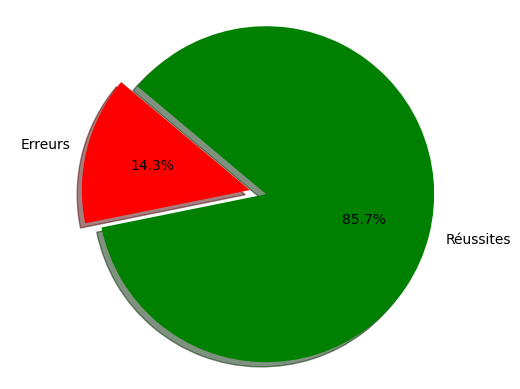


---------------------------------------------------
Tableau récapitulatif : 
  id   departure departure predict  destination destination predict
0  1    TOULOUSE          TOULOUSE     BORDEAUX            BORDEAUX
1  2       TOURS             TOURS  PORT BOULET         PORT BOULET
2  3    BORDEAUX          BORDEAUX        TOURS               TOURS
3  4      NANTES            NANTES     MONTAIGU             MONTEGU
4  5    NOT TRIP          NOT TRIP                                 
5  0    NOT TRIP          NOT TRIP                                 
6  7  NOT FRENCH        NOT FRENCH                                 
---------------------------------------------------



In [6]:
# Chemin du fichier d'entrée (id, phrases à analyser)
file_path_intput = './samples/sample_nlp_input_mispelled.txt'

# Chemin du fichier de sortie (triplets id, départ, destination)
file_path_output = './samples/sample_nlp_output.txt'

# lancement de l'analyse
analyse_nlp(file_path_intput, file_path_output)

## Conclusion

Analyse du premier fichier (sans faute) :

1,je voudrais aller de Toulouse à bordeaux
2,Comment me rendre à Port-Boulet depuis la gare de Tours ?
3,Je veux aller voir mon ami Albert à Tours en partant de Bordeaux
4,Il y a-t-il des trains de Nantes à Montaigu
5,Une phrase sans origine ni destination
Si pas de numéro de séquence, on considère que c'est zéro
7, is there any train going from Paris to Marseille ?

Taux de réussite sans prétraitement :
86%
Taux de réussite avec prétraitement :
100%

____________________________________

Analyse du deuxième fichier (avec fautes) :

1,je voudrais aller de toulouse à Bordau
2,Comment me rendre à Port-boulet depuis la gare de Tourrs ?
3,Je veux aller voir mon ami Albert à Toures en partant de Baurdeaux
4,Il y a-t-il des trains de Nanthes à Montégu
5,Une phrase sans origine ni destination
Si pas de numéro de séquence, on considère que c'est zéro
7, is there any train going from Parrie to Marceille ?

Taux de réussite sans prétraitement :
43%
Taux de réussite avec prétraitement :
86%